In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

In [2]:
glass_org = pd.read_csv('glass.csv')
glass_org

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Nie ma braków w danych:

In [3]:
glass_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Oznaczenia klas:<br>
-- 1 building windows float processed<br>
-- 2 building windows non float processed<br> 
-- 3 vehicle windows float processed<br>
-- 4 vehicle windows non float processed (none in this database)<br>
-- 5 containers<br>
-- 6 tableware<br>
-- 7 headlamps

Obejrzymy teraz wykresy pudełkowe oryginalnych danych:

In [6]:
def pokaz_pudelka(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.boxplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.boxplot(x="Type", y=atrybuty[i-2], data=glass)

In [7]:
def pokaz_skrzypce(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.violinplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.violinplot(x="Type", y=atrybuty[i-2], data=glass)

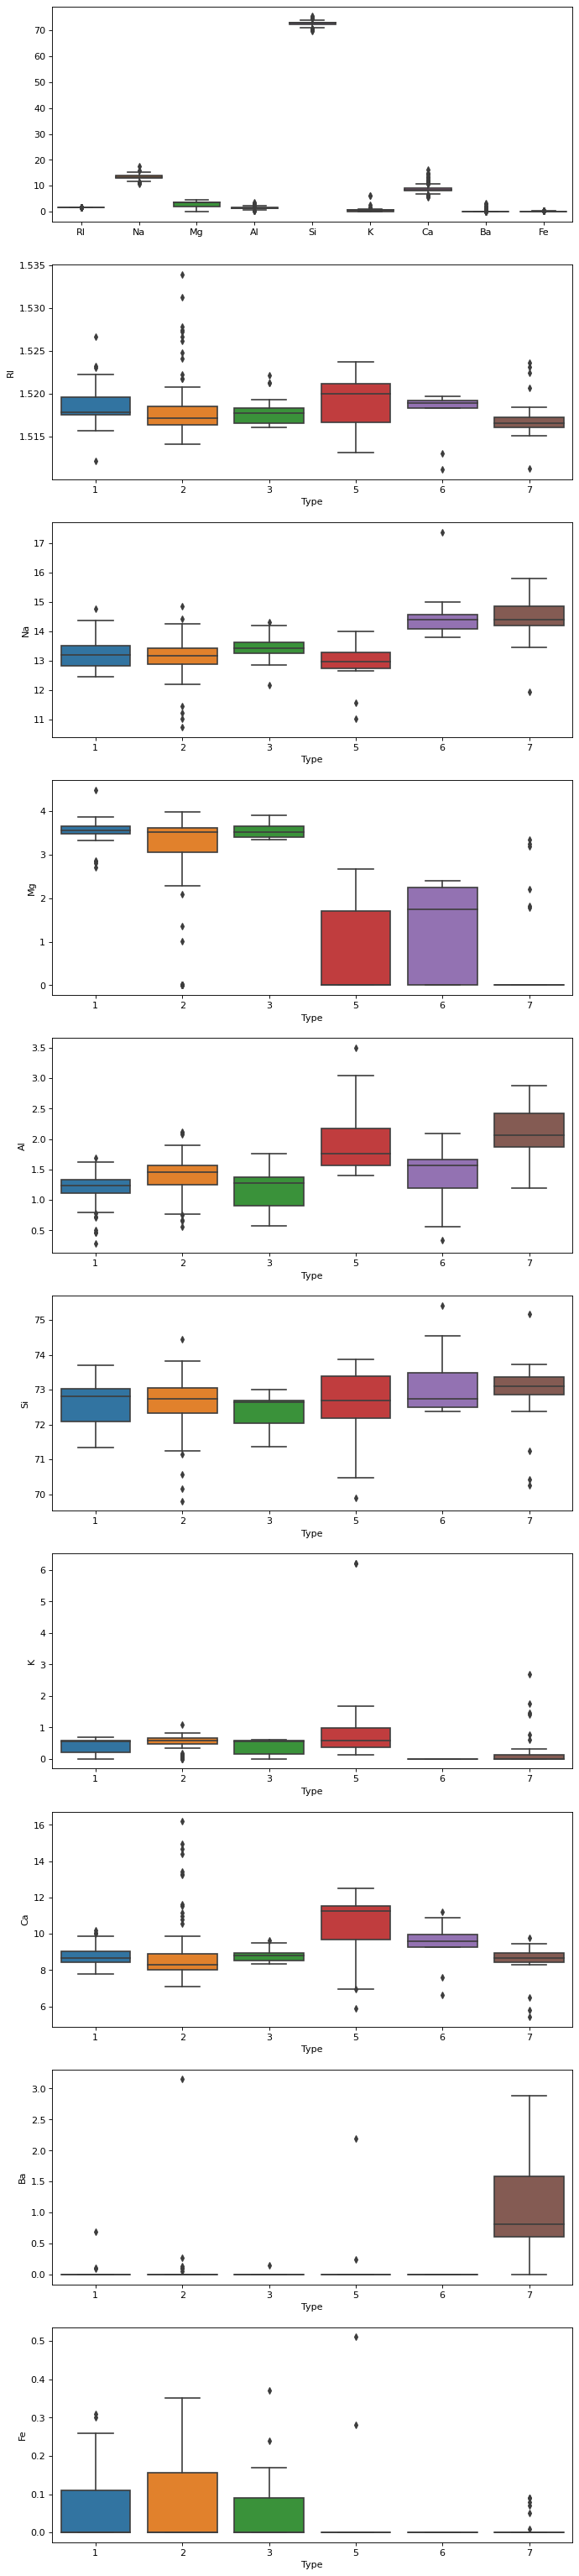

In [8]:
pokaz_pudelka(glass_org)

Oraz wykresy skrzypcowe:

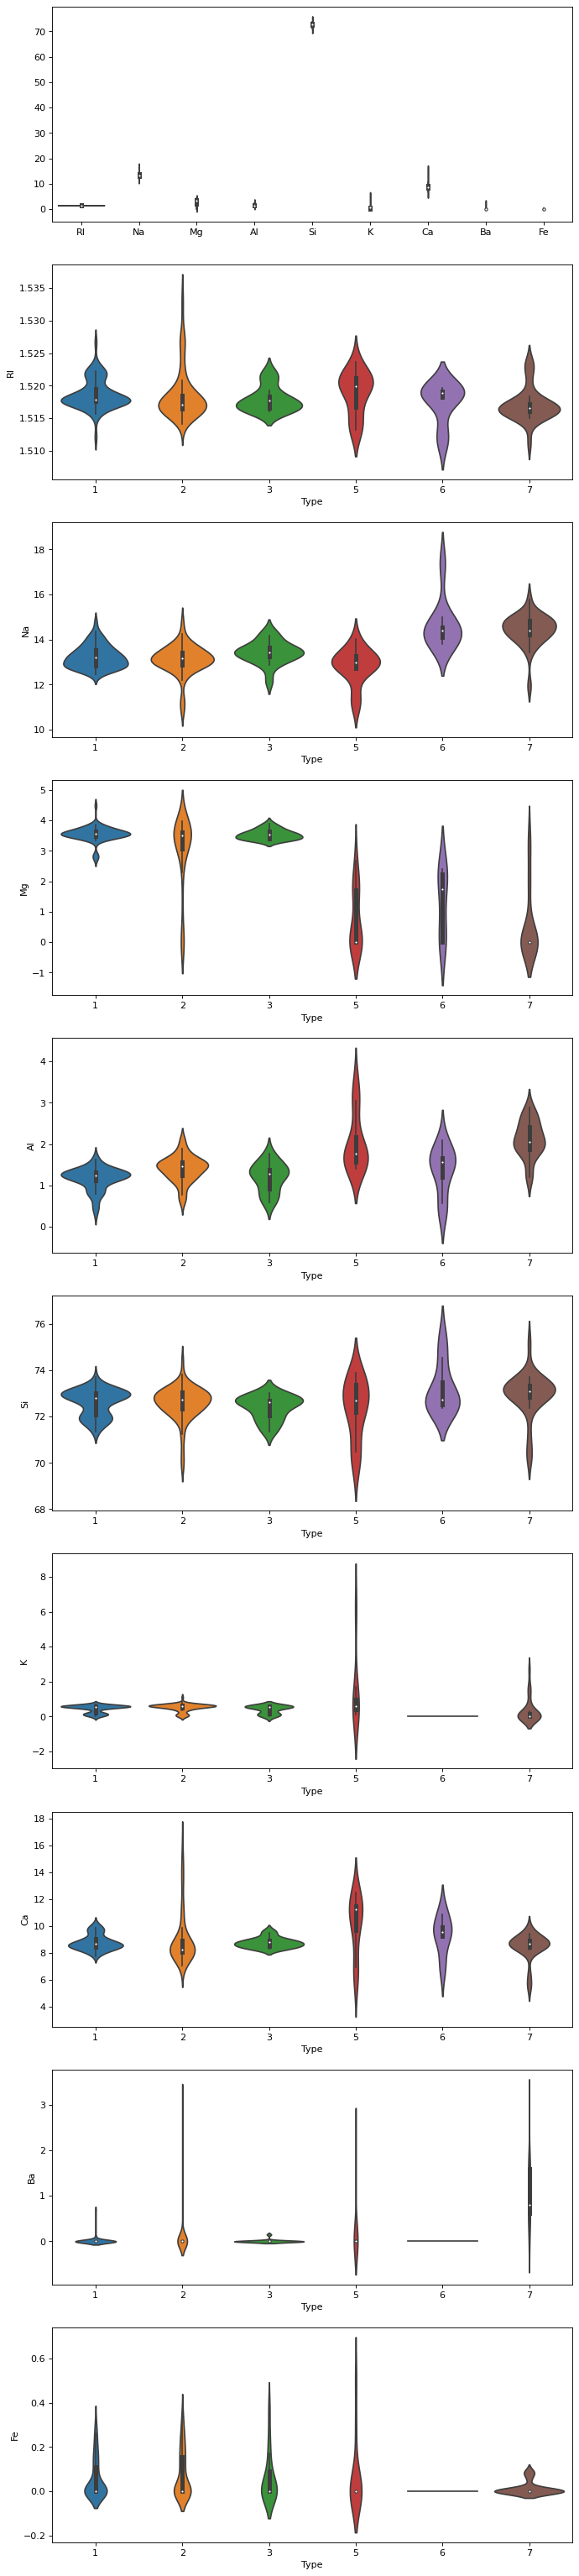

In [9]:
pokaz_skrzypce(glass_org)

Nierówna dystrybucja obiektów klas w zbiorze:

In [10]:
def class_distr(glass):
    ile_ob_klas = []
    for i in range(1,8):
        ile_ob_klas.append(glass[glass.Type == i].shape[0])
    ile_ob_klas = pd.DataFrame(ile_ob_klas, index=range(1,8), columns=['ilość obiektów'])
    print(ile_ob_klas)
    ile_ob_klas.plot(kind='bar')

   ilość obiektów
1              70
2              76
3              17
4               0
5              13
6               9
7              29


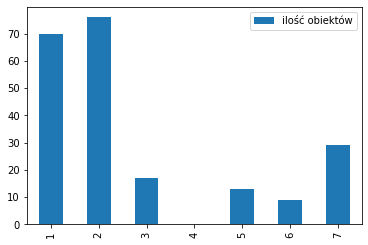

In [11]:
class_distr(glass_org)

Klasa 4 zostanie całkowicie pominięta w najstępujących rozważaniach i można ją traktować jako nieistniejącą. Z powodu braku jej próbek żaden obiekt nie będzie mógł zostać do niej przypisany.

Macierz korelacji Pearsona:

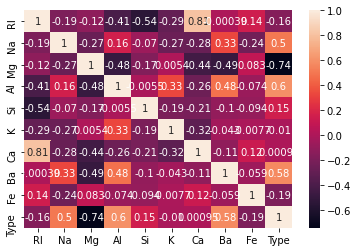

In [12]:
sns.heatmap(glass_org.corr(), annot = glass_org.corr())

Macierz wykresów punktowych:

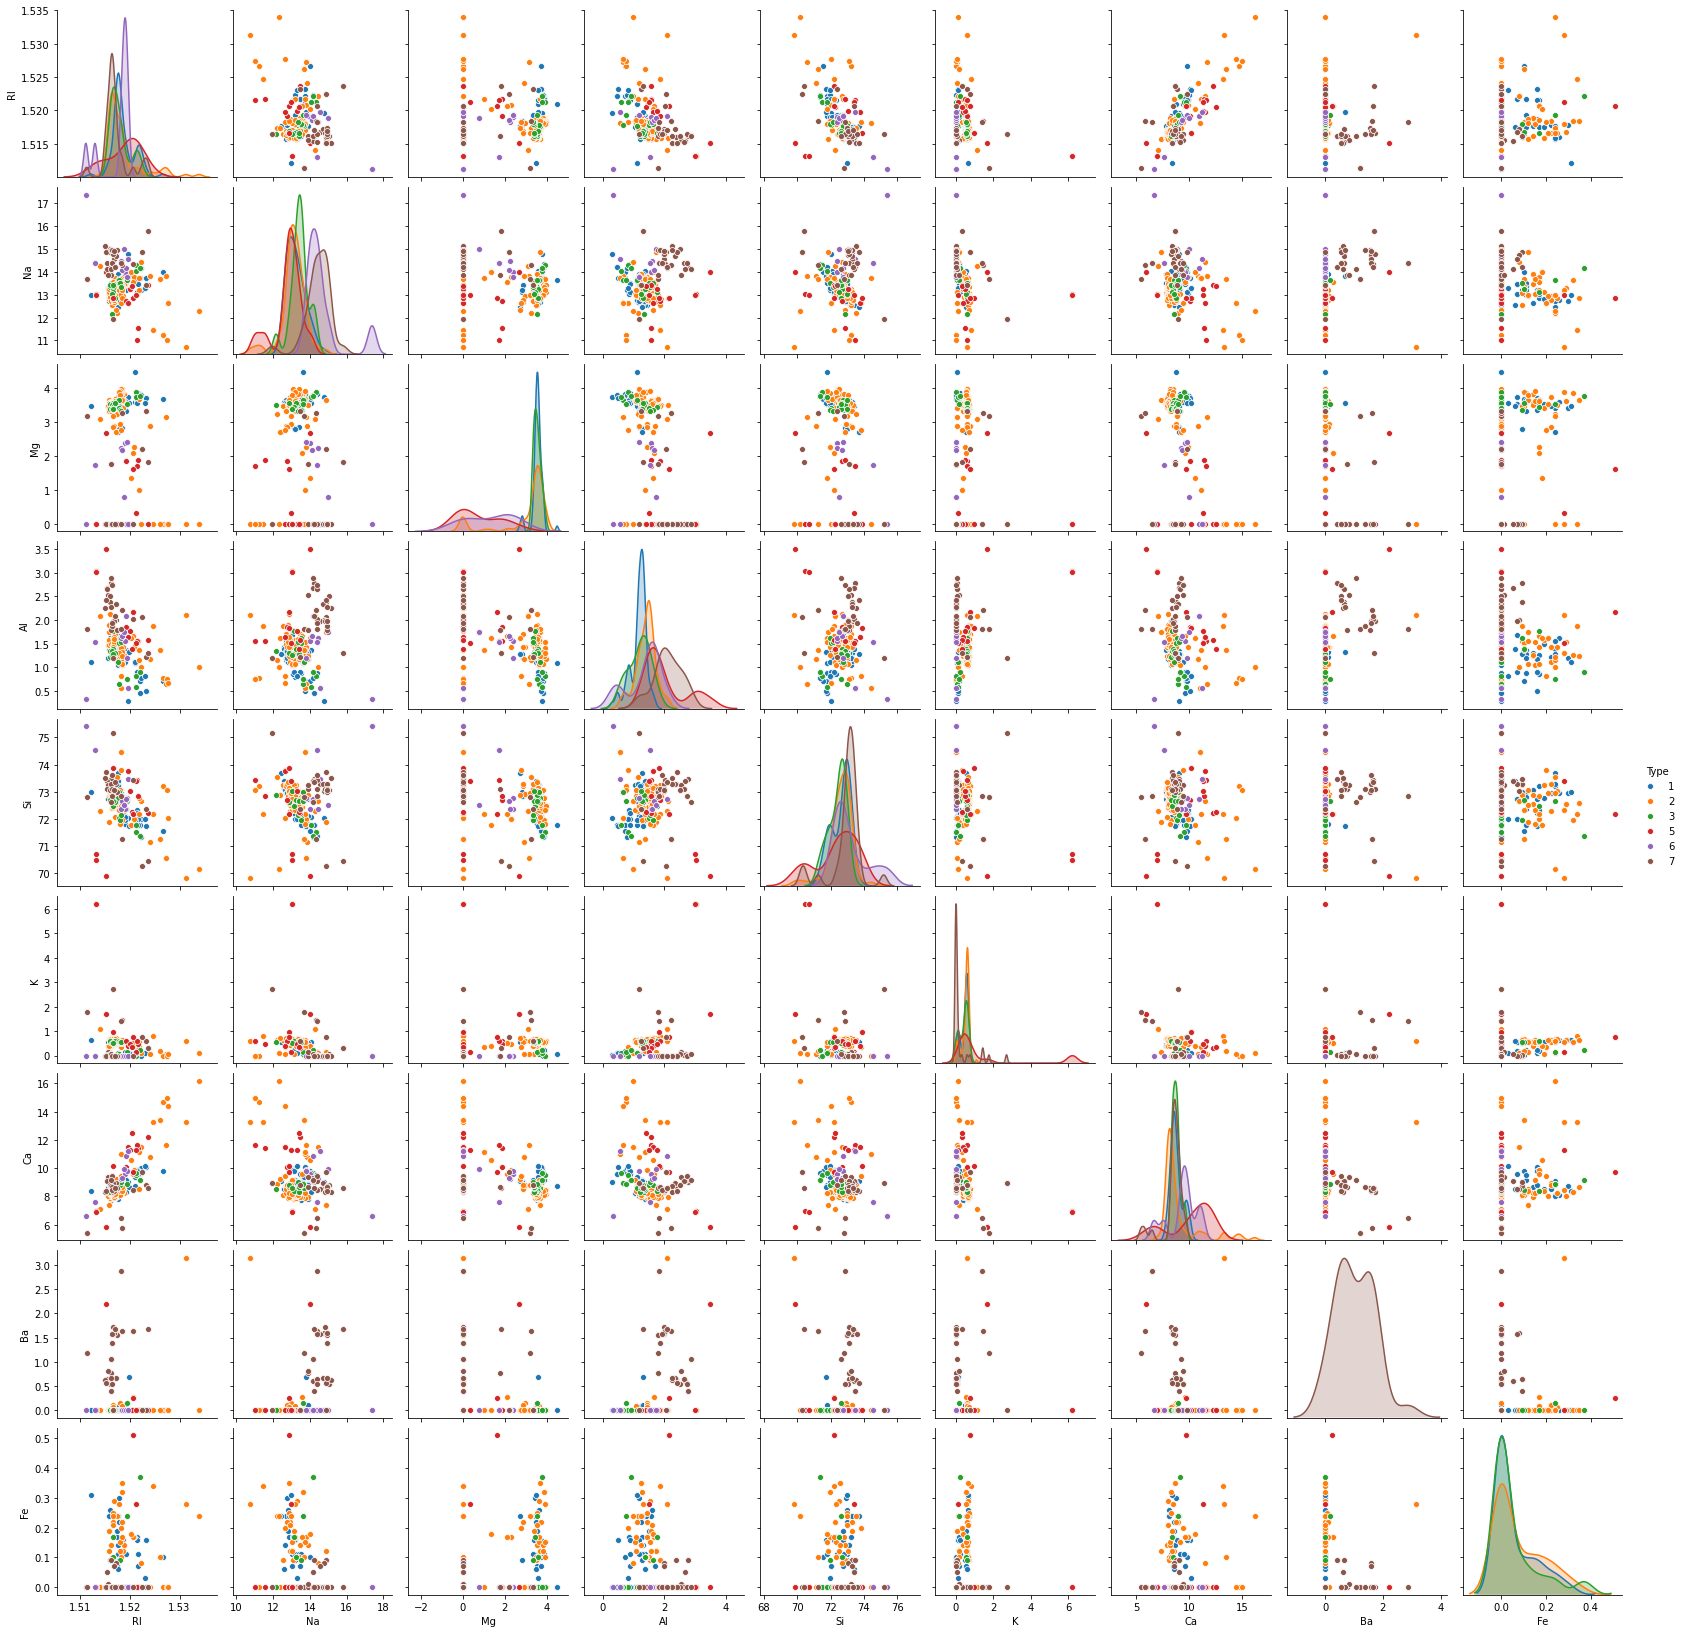

In [120]:
sns.pairplot(glass_org, kind="scatter", hue = "Type")

Rozwiązanie problemu nierównej dystrybucji klas z pomocą oversamplingu SMOTE:

In [13]:
sm = SMOTE()
X = glass_org.iloc[:,0:-1]
y = glass_org.iloc[:,-1]
X_resampled, y_resampled = sm.fit_resample(X, y)
glass_res = X_resampled
glass_res['Type'] = y_resampled

Wykresy pudełkowe zresamplowanego zbioru:

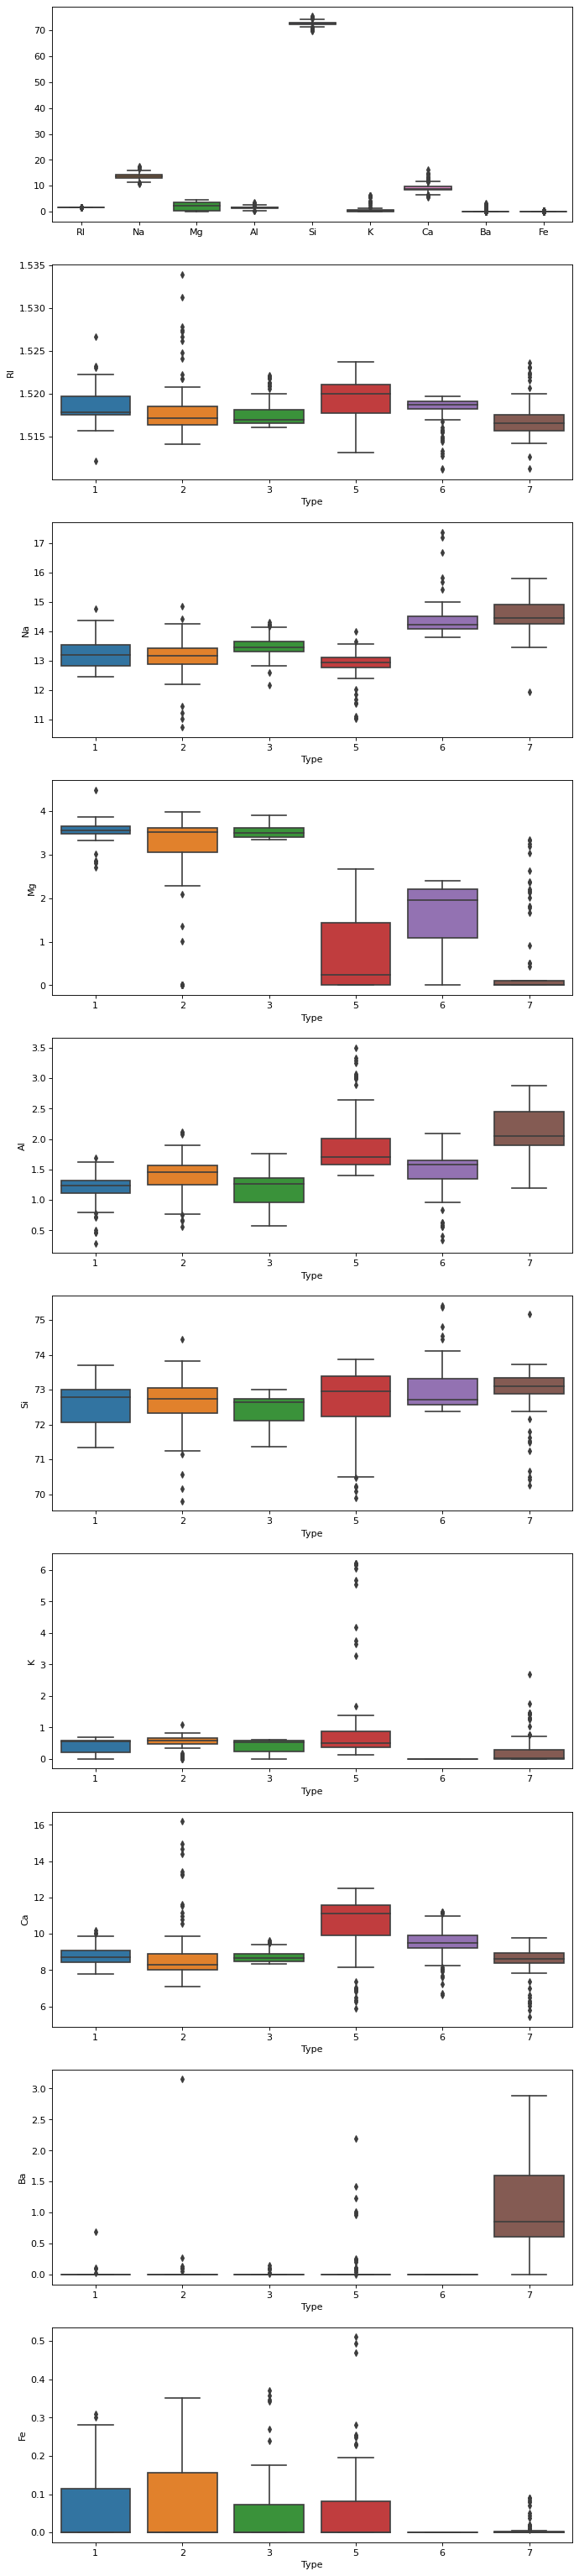

In [15]:
pokaz_pudelka(glass_res)

Wykresy skrzypcowe zresamplowanego zbioru:

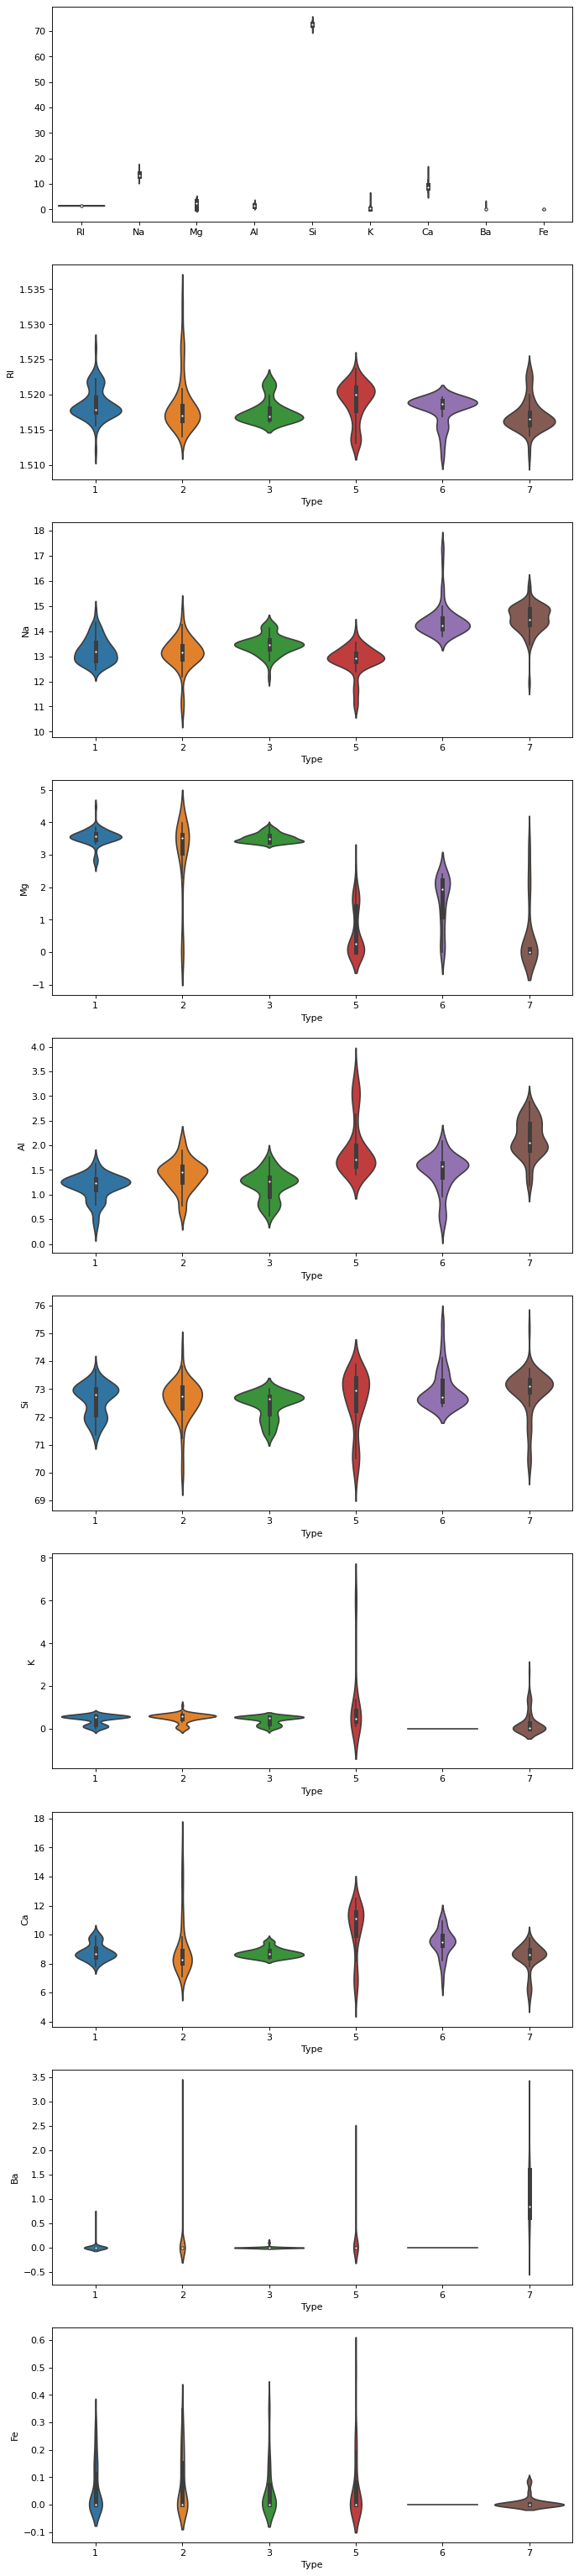

In [16]:
pokaz_skrzypce(glass_res)

   ilość obiektów
1              76
2              76
3              76
4               0
5              76
6              76
7              76


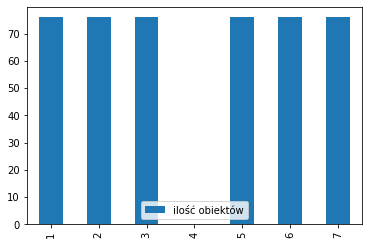

In [17]:
class_distr(glass_res)

Jak widać udało się wyrównać dystrubucje klas poza klasą, która od początku zawierała 0 obiektów.

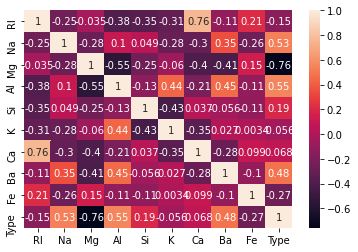

In [18]:
sns.heatmap(glass_res.corr(), annot = glass_res.corr())

Zawartość pierwiasta Ca mocno koreluje z Refractive index jednak nie wystarczająco by pominąć jeden z atrybutów.

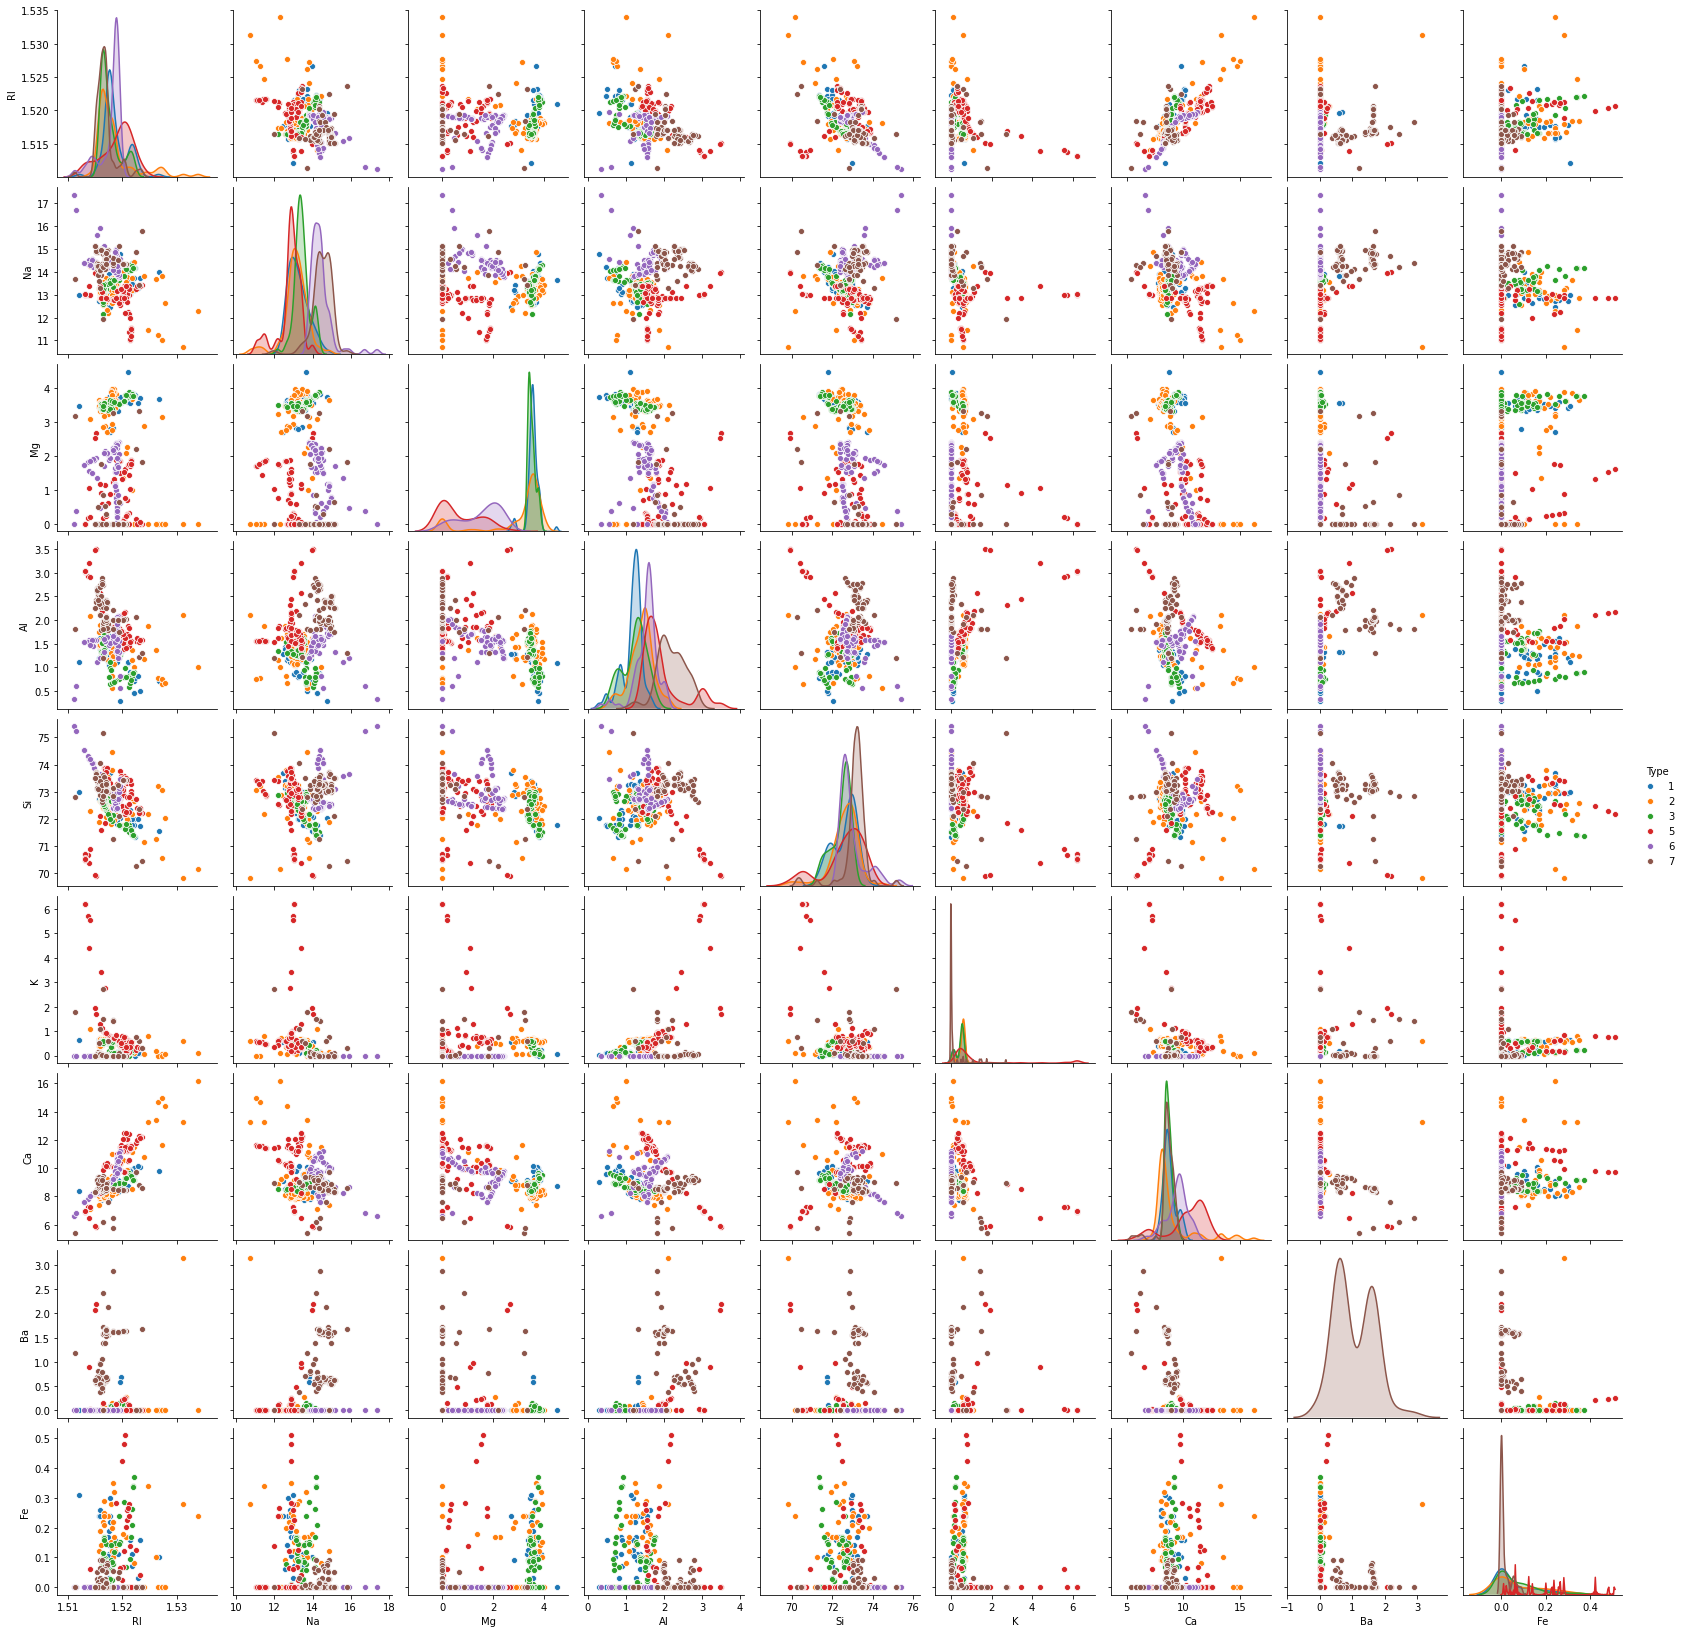

In [124]:
sns.pairplot(glass_res, kind="scatter", hue = "Type")

Podział zbioru na część uczącą i testową:

In [19]:
def podziel(df, proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(
        df.iloc[:,0:-1], df.iloc[:,-1], test_size=proporcja)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

Weryfikacja z użyciem macierzy pomyłek:

In [35]:
def weryfikuj(model, proporcja):
    #pozwala sprawdzić z pomocą macierzy pomyłek jak działa dany model
    #zawsze operuje na oversamplowanych danych glass
    glass_res_dict = podziel(glass_res, proporcja)
    model.fit(glass_res_dict["opis_ucz"], glass_res_dict["dec_ucz"])
    
    wynik_ucz = model.predict(glass_res_dict["opis_ucz"])
    wynik_test = model.predict(glass_res_dict["opis_test"])
    wynik_test_org = model.predict(glass_org.iloc[:,0:-1])
    
    print("Macierz pomyłek dla zbioru uczącego")
    print(pd.crosstab(glass_res_dict["dec_ucz"], wynik_ucz)) 
    wyn_test = model.score(glass_res_dict['opis_ucz'], glass_res_dict['dec_ucz'])
    print("Blad uczenia ", 1-wyn_test)
    
    print("\nMacierz pomyłek dla zbioru testowego")
    print(pd.crosstab(glass_res_dict["dec_test"], wynik_test)) 
    wyn_test = model.score(glass_res_dict['opis_test'], glass_res_dict['dec_test'])
    print("Blad testowania ", 1-wyn_test)
    
    print("\nMacierz pomyłek dla zbioru oryginalnego")
    print(pd.crosstab(glass_org.iloc[:,-1], wynik_test_org))
    wyn_test = model.score(glass_org.iloc[:,0:-1], glass_org.iloc[:,-1])
    print("Blad tesowania na zbiorze oryginalnym ", 1-wyn_test)

In [73]:
def wykres_bledu(max_k, proporcja):
    #tworzy wykres bledu dla algorytmu kNN by wybrać najlepsze k
    #testuje jak model klasyfikuje dane oryginalne czyli sprzed oversamplingu
    glass_res_dict = podziel(glass_res, proporcja)
    wyniki = []
    for i in range(1,max_k+1):
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(glass_res_dict["opis_ucz"], glass_res_dict["dec_ucz"])
        wyn_test_org = 1-model.score(glass_org.iloc[:,0:-1], glass_org.iloc[:,-1])
        wyniki.append(wyn_test_org)
    kwart = pd.DataFrame(wyniki, index=range(1,max_k+1))
    plt.figure(dpi=90)
    plt.plot(kwart,'bo-')
    plt.title('Wykres bledu')
    plt.xlabel('Liczba sasiadow')
    plt.ylabel('Prawdopodobienstwo bledu')

Jak widać poniżej najlepsze wyniki mamy dla k=1:

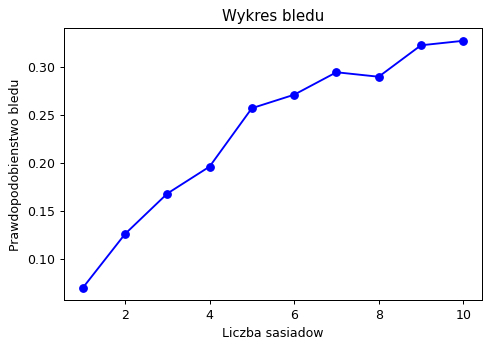

In [74]:
wykres_bledu(10, 0.3)

Zaskakująco dobre wyniki tak prostego algorytmu uczenia leniwego. Być może za bardzo dopasowany do zbioru uczącego. Akceptowalny błąd zbioru testowego oraz bardzo mały błąd na oryginalnych danych (sprzed oversamplingu):

In [70]:
model = KNeighborsClassifier(n_neighbors=1)
weryfikuj(model, 0.3)

Macierz pomyłek dla zbioru uczącego
col_0   1   2   3   5   6   7
Type                         
1      57   0   0   0   0   0
2       0  52   0   0   0   0
3       0   0  62   0   0   0
5       0   0   0  50   0   0
6       0   0   0   0  51   0
7       0   0   0   0   0  47
Blad uczenia  0.0

Macierz pomyłek dla zbioru testowego
col_0   1   2   3   5   6   7
Type                         
1      15   2   2   0   0   0
2       5  15   4   0   0   0
3       2   0  11   0   0   1
5       0   0   0  26   0   0
6       0   0   0   0  25   0
7       0   2   0   1   2  24
Blad testowania  0.15328467153284675

Macierz pomyłek dla zbioru oryginalnego
col_0   1   2   3   5  6   7
Type                        
1      67   1   2   0  0   0
2       5  67   4   0  0   0
3       1   0  16   0  0   0
5       0   0   0  13  0   0
6       0   0   0   0  9   0
7       0   1   0   1  1  26
Blad tesowania na zbiorze oryginalnym  0.07476635514018692


Już na pierwszy rzut oka widać, że ten algorytm nie będzie dla nas pomocny, gdyż ma bardzo kiepskie wyniki:

In [75]:
model = NearestCentroid()
weryfikuj(model, 0.3)

Macierz pomyłek dla zbioru uczącego
col_0   1  2   3   5   6   7
Type                        
1      24  6  16   0   0   0
2      26  6  13   9   2   0
3      25  0  28   0   0   0
5       0  2   0  52   0   3
6       0  1   0   4  45   3
7       0  1   4   0   1  48
Blad uczenia  0.36363636363636365

Macierz pomyłek dla zbioru testowego
col_0   1  2   3   5   6   7
Type                        
1      18  5   7   0   0   0
2      12  3   5   0   0   0
3      13  0  10   0   0   0
5       0  0   0  17   0   2
6       0  0   0   0  22   1
7       0  0   2   1   3  16
Blad testowania  0.3722627737226277

Macierz pomyłek dla zbioru oryginalnego
col_0   1  2   3   5  6   7
Type                       
1      40  9  21   0  0   0
2      38  9  18   9  2   0
3       9  0   8   0  0   0
5       0  1   0  11  0   1
6       0  1   0   1  6   1
7       0  0   3   1  2  23
Blad tesowania na zbiorze oryginalnym  0.5467289719626168


Wyniki lepsze niż w algorytmie najbliższego centroidu jednak wciąż nieakceptowalne i o wiele gorsze niż w kNN=1:

In [76]:
model = GaussianNB()
weryfikuj(model, 0.3)

Macierz pomyłek dla zbioru uczącego
col_0   1  2   3   5   6   7
Type                        
1      32  1  19   0   1   0
2      37  7  10   3   2   0
3       6  1  41   0   1   0
5       0  9   0  37   0   0
6       0  0   0   0  57   0
7       1  1   0   0   0  53
Blad uczenia  0.28840125391849525

Macierz pomyłek dla zbioru testowego
col_0   1  2   3   5   6   7
Type                        
1      14  1   8   0   0   0
2       8  4   2   1   1   1
3       5  0  22   0   0   0
5       0  5   0  22   0   3
6       0  0   0   0  19   0
7       0  1   0   1   0  19
Blad testowania  0.27007299270072993

Macierz pomyłek dla zbioru oryginalnego
col_0   1   2   3  5  6   7
Type                       
1      42   2  25  0  1   0
2      45  11  12  4  3   1
3       3   1  12  0  1   0
5       0   3   0  9  0   1
6       0   0   0  0  9   0
7       1   0   0  1  0  27
Blad tesowania na zbiorze oryginalnym  0.485981308411215


Drzewo decyzyjne daje najlepsze wyniki (poza kNN=1) jednak wciąż są one o wiele gorsze niż kNN=1:

In [77]:
model = tree.DecisionTreeClassifier(max_depth=4)
weryfikuj(model, 0.3)

Macierz pomyłek dla zbioru uczącego
col_0   1   2   3   5   6   7
Type                         
1      32   4  19   0   0   0
2      13  32   4   0   0   0
3       0   0  56   0   0   0
5       0   0   0  55   0   0
6       0   0   0   0  53   0
7       0   0   0   0   0  51
Blad uczenia  0.12539184952978055

Macierz pomyłek dla zbioru testowego
col_0   1   2   3   5   6   7
Type                         
1      14   0   7   0   0   0
2       4  15   4   2   2   0
3       0   0  20   0   0   0
5       0   1   0  19   0   1
6       0   0   0   0  23   0
7       0   1   2   1   1  20
Blad testowania  0.1897810218978102

Macierz pomyłek dla zbioru oryginalnego
col_0   1   2   3   5  6   7
Type                        
1      42   4  24   0  0   0
2      17  47   8   2  2   0
3       0   0  17   0  0   0
5       0   0   0  12  0   1
6       0   0   0   0  9   0
7       0   0   1   1  1  26
Blad tesowania na zbiorze oryginalnym  0.2850467289719626


Stworzono model kNN=1 który daje dobre wyniki zarówno na oversamplowanym zbiorze uczącym i testowym jak i na oryginalnych danych (sprzed oversamplingu). 